In [50]:
from PIL import Image
import os
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

In [51]:
def str_2_float(line):
    return [float(e) for e in line.strip().split()]


def read_txt(path):
    with open(path, "r") as f:
        lines = f.readlines()

    lines = [str_2_float(line) for line in lines]
    return np.array(lines)


def crop_imgs(root):
    os.makedirs(os.path.join(root, "no"), exist_ok=True)
    os.makedirs(os.path.join(root, "yes"), exist_ok=True)

    for img_name in os.listdir(os.path.join(root, "images")):
        name = os.path.splitext(img_name)[0]
        metadata_name = name + ".txt"
        img = np.array(Image.open(os.path.join(root, "images", img_name)))
        metadatas = read_txt(os.path.join(root, "labels", metadata_name))
        height, width = img.shape[:2]

        for i in range(metadatas.shape[0]):
            class_id, x_center, y_center, w, h = metadatas[i]
            start_x = int(width * (x_center - w / 2))
            start_y = int(height * (y_center - h / 2))
            end_x = start_x + int(w * width)
            end_y = start_y + int(h * height)
            img_instance = img[start_y:end_y, start_x:end_x, :]

            if class_id == 0:  # uniform
                Image.fromarray(img_instance).save(
                    os.path.join(root, "yes", f"{name}_{i}.jpg")
                )
            else:  # no uniform
                Image.fromarray(img_instance).save(
                    os.path.join(root, "no", f"{name}_{i}.jpg")
                )

In [ ]:
root = "scraped/train"
for dir in os.listdir(root):
    os.makedirs("processed_imgs/")

In [ ]:
import torch
import torchvision
import lightning as L
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTForImageClassification, ViTConfig
from models import *

model = ViT.load_from_checkpoint(
    "uniform_classification/easop82o/checkpoints/best.ckpt"
)

model.eval()

ViT(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (inter

In [ ]:
import time

for _ in range(20):
    start = time.time()
    with torch.no_grad():
        output = model(torch.randn(1, 3, 224, 224, device="cuda"))
    print(time.time() - start)

0.19158172607421875
0.005522251129150391
0.004069089889526367
0.003927946090698242
0.0039038658142089844
0.003877401351928711
0.003873109817504883
0.0038738250732421875
0.004007816314697266
0.0038759708404541016
0.00384521484375
0.003873109817504883
0.0038454532623291016
0.0041201114654541016
0.0038690567016601562
0.003873109817504883
0.003906726837158203
0.0039293766021728516
0.0038907527923583984
0.005156517028808594


In [ ]:
model.device

device(type='cuda', index=0)

In [48]:
import glob
import os

long = glob.glob("datasets/uniform_bidv/raw/yes/bidv_long_front/*")
short = glob.glob("datasets/uniform_bidv/raw/yes/bidv_short*/*")
no = glob.glob("datasets/uniform_bidv/raw/no/*/*")
len(long), len(short), len(no)

(4584, 9168, 11335)

In [49]:
len(os.listdir("datasets/uniform_bidv/raw/no/cropped_inria_person"))

1837

In [50]:
X = long + short + no
y_binary = [1] * (len(long) + len(short)) + [0] * len(no)
y_3_classes = [1] * len(long) + [2] * len(short) + [0] * len(no)

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1875, random_state=42, stratify=y_train
)

In [52]:
def get_n_long_short(X, y):
    n_long, n_short = 0, 0
    for path, label in zip(X, y):
        if label == 1:
            if "long" in path.split("/")[4]:
                n_long += 1
            else:
                n_short += 1
    print(n_long, n_short, n_short / n_long)


get_n_long_short(X_train, y_train)
get_n_long_short(X_val, y_val)
get_n_long_short(X_test, y_test)

2990 5948 1.9892976588628764
688 1375 1.998546511627907
906 1845 2.0364238410596025


In [53]:
import pandas as pd

df_train = pd.DataFrame({"path": X_train, "label": y_train})
df_val = pd.DataFrame({"path": X_val, "label": y_val})
df_test = pd.DataFrame({"path": X_test, "label": y_test})

df_train.to_csv("datasets/uniform_bidv/binary/train.csv", index=False)
df_val.to_csv("datasets/uniform_bidv/binary/val.csv", index=False)
df_test.to_csv("datasets/uniform_bidv/binary/test.csv", index=False)

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_3_classes, test_size=0.2, random_state=42, stratify=y_3_classes
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1875, random_state=42, stratify=y_train
)

In [ ]:
import pandas as pd

df_train = pd.DataFrame({"path": X_train, "label": y_train})
df_val = pd.DataFrame({"path": X_val, "label": y_val})
df_test = pd.DataFrame({"path": X_test, "label": y_test})

In [56]:
df_train["label"].value_counts() / len(df_train.index)

label
0    0.451858
2    0.365448
1    0.182693
Name: count, dtype: float64

In [57]:
df_val["label"].value_counts() / len(df_val.index)

label
0    0.451767
2    0.365400
1    0.182833
Name: count, dtype: float64

In [58]:
df_test["label"].value_counts() / len(df_test.index)

label
0    0.451774
2    0.365484
1    0.182742
Name: count, dtype: float64

In [59]:
df_train.to_csv("datasets/uniform_bidv/three_classes/train.csv", index=False)
df_val.to_csv("datasets/uniform_bidv/three_classes/val.csv", index=False)
df_test.to_csv("datasets/uniform_bidv/three_classes/test.csv", index=False)

In [60]:
import cv2

s_height, s_width = 0, 0
for path in no:
    img = cv2.imread(path)
    s_height += img.shape[0]
    s_width += img.shape[1]
    if img.shape[0] / img.shape[1] <= 0.8:
        print(path)
        print(img.shape[0] / img.shape[1])
print(s_height / len(no), s_width / len(no))

datasets/uniform_bidv/raw/no/yellow_shirt/00027-564160557.jpg
0.7342995169082126
datasets/uniform_bidv/raw/no/black_shirt_man/00592-3097153832.jpg
0.6519480519480519
datasets/uniform_bidv/raw/no/orange_shirt/00313-37124169692.jpg
0.7435897435897436
datasets/uniform_bidv/raw/no/orange_shirt/00483-3712417139.jpg
0.787109375
datasets/uniform_bidv/raw/no/green_shirt/00636-38548885452.jpg
0.3953488372093023
datasets/uniform_bidv/raw/no/black_hoodie_man/00123-2528966523.jpg
0.771875
datasets/uniform_bidv/raw/no/white_hoodie_woman/00758-15985693792.jpg
0.5147058823529411
datasets/uniform_bidv/raw/no/violet_shirt/00346-1992601935.jpg
0.26382978723404255
datasets/uniform_bidv/raw/no/red_shirt/00019-26594043432.jpg
0.7884615384615384
datasets/uniform_bidv/raw/no/black_jacket_woman/00035-41412510563.jpg
0.5283018867924528
datasets/uniform_bidv/raw/no/black_jacket_woman/00035-41412510562.jpg
0.5617977528089888
388.2516100573445 172.78341420379357


In [20]:
from preprocessing import BIDVUniformDataset

dt = BIDVUniformDataset("datasets/uniform_bidv/three_classes", batch_size=8)

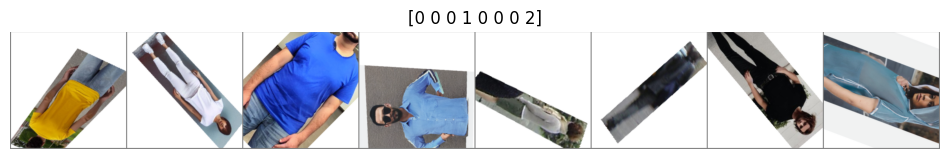

In [27]:
dt.visualize()

In [1]:
import cv2
from PIL import Image
import time

image_path = "datasets/uniform_bidv/raw/yes/bidv_long_front/00000-2529974_0.png"
target_size = (300, 200)

# OpenCV
start = time.time()
image_cv2 = cv2.imread(image_path)
resized_cv2 = cv2.resize(image_cv2, target_size, interpolation=cv2.INTER_LINEAR)
end = time.time()
print(f"OpenCV resize time: {end - start:.4f} seconds")

# Pillow
start = time.time()
image_pillow = Image.open(image_path)
resized_pillow = image_pillow.resize(target_size, Image.BILINEAR)
end = time.time()
print(f"Pillow resize time: {end - start:.4f} seconds")

OpenCV resize time: 0.0246 seconds
Pillow resize time: 0.0341 seconds


In [1]:
from exporting import ONNXEvaluator

evaluator = ONNXEvaluator("a", "b")

/home/htsc/nguyentd/classification/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
img = evaluator.preprocess(
    "datasets/uniform_bidv/raw/no/black_hoodie_man/00152-2528966552.jpg"
)

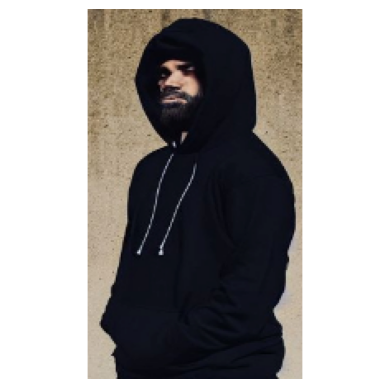

In [23]:
import matplotlib.pyplot as plt

img = img.squeeze(0).transpose(1, 2, 0)
img = (img * 0.5 + 0.5) * 255
img = img.astype(np.uint8)
plt.imshow(img)
plt.axis("off")
plt.show()

In [24]:
img.shape, img.dtype, img.max()

((224, 224, 3), dtype('uint8'), 255)

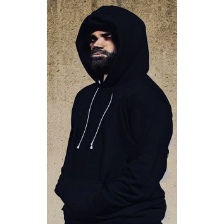

In [25]:
from PIL import Image
import numpy as np

Image.fromarray(img.astype(np.uint8)).show()